[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fadheladlansyah/<repo>/blob/master/<filename>.ipynb)

# 0. Set access to kaggle and download dataset

In [0]:
# !pip install -q kaggle

# upload kaggle API key file
# from google.colab import files
# uploaded = files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# download dataset
!kaggle competitions download -c ieee-fraud-detection -p ./data -q

mkdir: cannot create directory ‘/root/.kaggle’: File exists


# 1. Libraries

In [3]:
import numpy as np
import pandas as pd
pd.options.display.precision = 10
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

# from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

import random
from tqdm import tqdm_notebook

import os
import gc
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Load dataset

### Download dataset

This dataset is part of a kaggle competition held by IEEE-CIS. There are training data and testing data (no label). For the sake of this exploration, I only use the training data.

In [0]:
# only use train data
folder_path = './data/'
identities = pd.read_csv(f'{folder_path}train_identity.csv.zip')
transactions = pd.read_csv(f'{folder_path}train_transaction.csv.zip')

df = pd.merge(transactions, identities, on='TransactionID', how='left')

__Transactions Table__

- TransactionsID: unique transaction identitiy number
- isFraud: label
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain R_emaildomain
- M1 - M9

In [5]:
transactions.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [6]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


__Identity Table__

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)
- TransactionsID: unique transaction identitiy number

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

In [7]:
identities.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [8]:
identities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


### Reduce data memory usage

- Reduce memory usage to reduce posibilities in failing the training due to short of memory

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage has been reduced from {:6.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'
              .format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [11]:
del transactions
del identities
df = reduce_mem_usage(df)

# df_1 = df.copy()

Mem. usage has been reduced from 1959.88 Mb to 650.48 Mb (66.8% reduction)


# 3. Data Exploration



### Missing Data

- Columns which have more than 90% null values. consider to __drop__. While it is totally common to get many null attribute, the feature would give no predictive power.

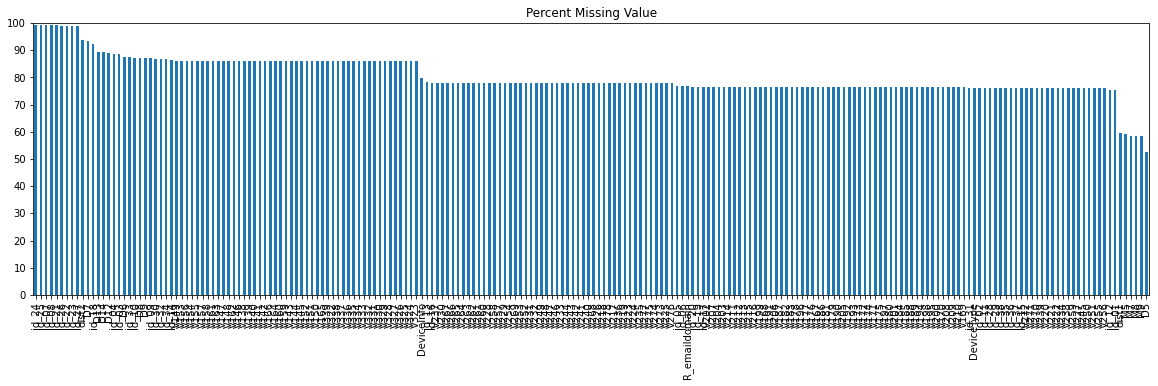

In [12]:
temp = df.isnull().sum().sort_values(ascending=False).apply(lambda x: x/len(df)*100)
temp = temp[temp > 50]

plt.figure(figsize=(20,5))
temp.plot.bar(ylim=(0,100), yticks=range(0,101,10), title='Percent Missing Value');

### Label

Not Frauds 96.5 % of the dataset, total of 569877
Frauds 3.5 % of the dataset, total of 20663


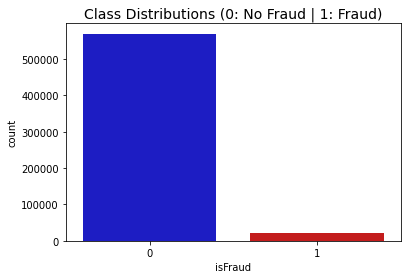

In [13]:
def label_counts(series):
  number_of_notFraud = series.value_counts()[0]
  number_of_Fraud = series.value_counts()[1]
  print('Not Frauds', round(number_of_notFraud/series.shape[0]*100, 2), '% of the dataset, total of', number_of_notFraud)
  print('Frauds', round(number_of_Fraud/series.shape[0]*100,2), '% of the dataset, total of', number_of_Fraud)

label_counts(df['isFraud'])

colors = ["#0101DF", "#DF0101"]
sns.countplot('isFraud', data=df, palette=colors)
plt.title('Class Distributions (0: No Fraud | 1: Fraud)', fontsize=14);

Notice how __imbalanced__ is the dataset! Most of the transactions are not-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

What usually works
- Collect more data, but not applicable
- Change the performance metric:
  - Use Precision, Recall
  - Use F1score (weighted average of precision recall)
  - Use Kappa - classification accuracy normalized by the imbalance
  - ROC curves - sensitivity/specificity ratio
- Resample the dataset, a method to get about 50-50 class ratio
  - OVER-sampling - adding copies of the under-represented class (better for small data)
  - UNDER-sampling - deleting instances from the over-represented class (better for a lot data)

### ID

- id_01 - id_11 are continuous variables
- left high-skewed : id_01, id_06
- right high-skewed : id_02
- Some seems are already normalized (id_03, id_07, id_08, id_09)
- Each have high number of null values
- `id_03` 88% values are Null, 10% values are 0. seems __not useful__
- `id_04` 88% values are Null, 11% values are 0. seems __not useful__
- `id_07`, `id_08` 99% values are Null. consider to __drop__
- `id_09` 87% values are Null, 12% values are 0. seems __not useful__
- `id_10` 87% values are Null, 12% values are 0. seems __not useful__
- `id_11` 76% values are Null, 22% values are 100. strange but seems __not useful__

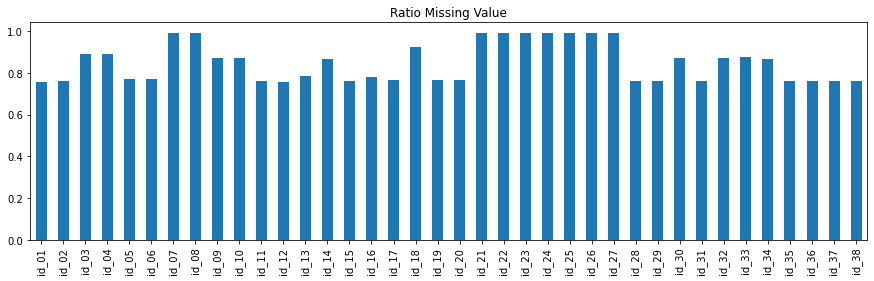

In [14]:
features = [col for col in df.columns if col[:3] == 'id_']

plt.figure(figsize=(15,4))            
df[features].isna().sum().apply(lambda x: x/len(df)).plot.bar(title='Ratio Missing Value');

In [15]:
features = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
            # 'id_07', 'id_08',
            'id_09', 'id_10', 'id_11']

df[features].describe()

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11
count,144233.0,140872.0000,66324.0000000000,66324.0000000000,136865.0,136865.0,74926.0000000000,74926.0000000000,140978.0
mean,NaN,174716.9375,0.0600891113,-0.0590515137,NaN,NaN,0.0911865234,-0.3010253906,NaN
std,0.0,159650.0000,0.5981445312,0.7011718750,0.0,0.0,0.0000000000,0.0000000000,0.0
min,-100.0,1.0000,-13.0000000000,-28.0000000000,-72.0,-100.0,-36.0000000000,-100.0000000000,90.0
25%,-10.0,67992.0000,0.0000000000,0.0000000000,0.0,-6.0,0.0000000000,0.0000000000,100.0
50%,-5.0,125800.5000,0.0000000000,0.0000000000,0.0,0.0,0.0000000000,0.0000000000,100.0
75%,-5.0,228749.0000,0.0000000000,0.0000000000,1.0,0.0,0.0000000000,0.0000000000,100.0
max,0.0,999595.0000,10.0000000000,0.0000000000,52.0,0.0,25.0000000000,0.0000000000,100.0


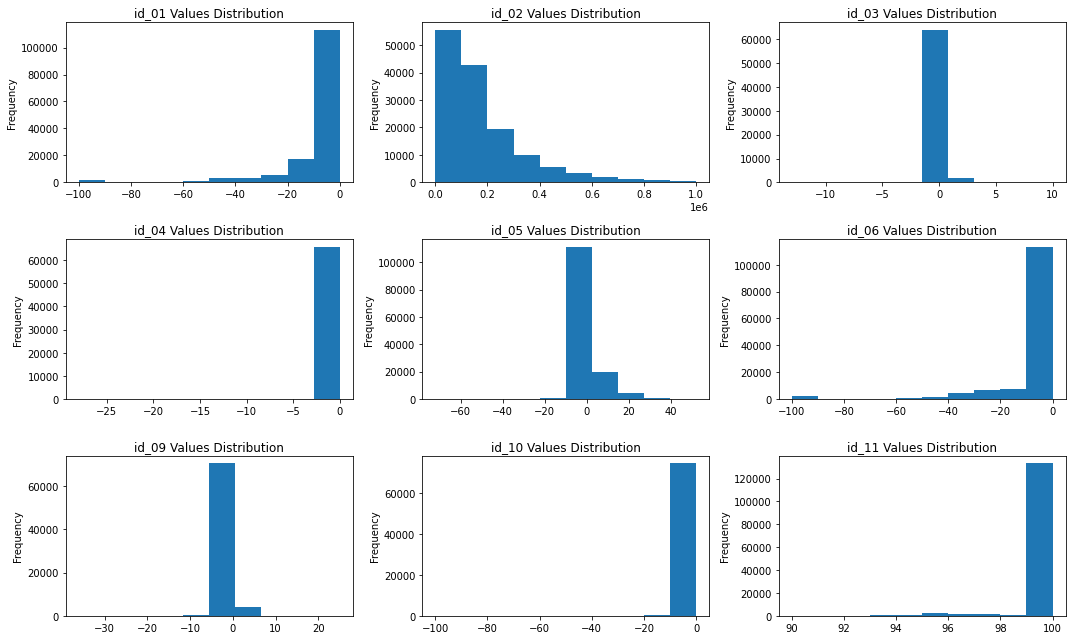

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(15,9), tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    if i <= len(features)-1:
        # display(df[feature].value_counts(dropna=False, normalize=True, ascending=False))
        df[features[i]].plot.hist(title=f"{features[i]} Values Distribution", ax=ax);
    else:
        ax.set_visible(False)

- id_12 - id_38 are categorical variables, but some are already in numeric
- mostly are binary condition
- Each have high number of null values
- `id_21`,`id_22`,`id_23`,`id_24`,`id_25`,`id_26`,`id_27` 99% values are Null. consider to __drop__
- `id_30` operating system
- `id_31` browser
- `id_33` screen res
- `id_30`, `id_31`, `id_33` have large categories, hundreds.


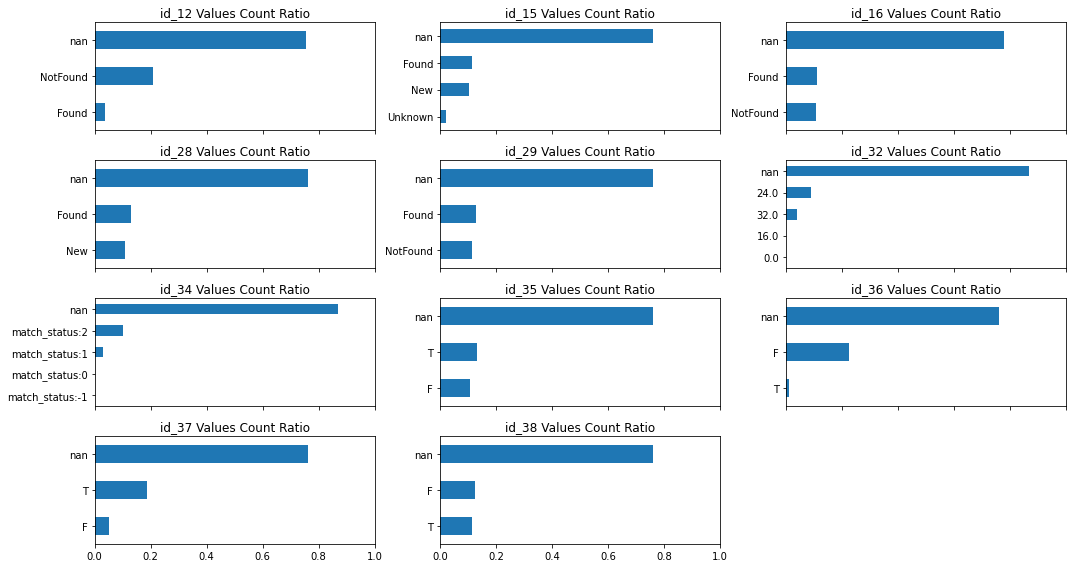

In [17]:
features = ['id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

fig, axes = plt.subplots(4, 3, sharex=True, figsize=(15,8), tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    if i <= len(features)-1:
        df[features[i]].value_counts(dropna=False, normalize=True, ascending=True)\
          .plot.barh(xlim=(0,1), title=f"{features[i]} Values Count Ratio", ax=ax);
    else:
        ax.set_visible(False)

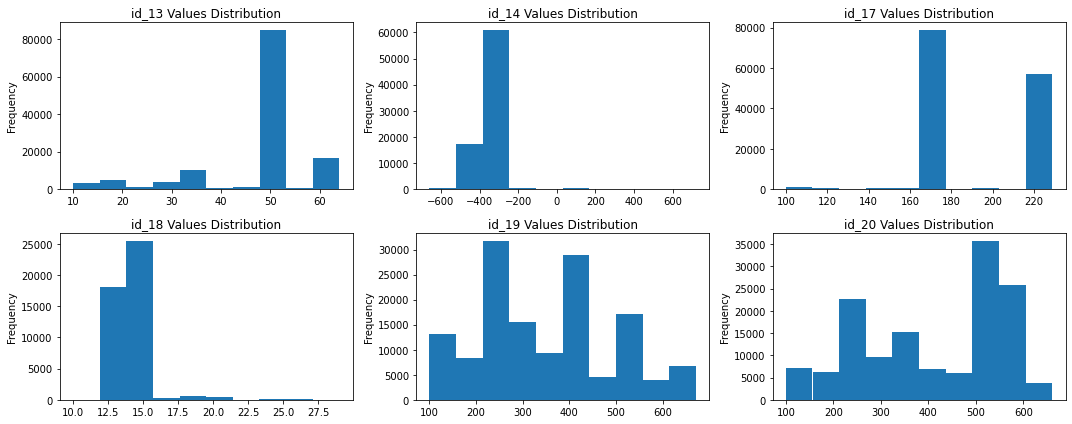

In [18]:
features = ['id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20']

fig, axes = plt.subplots(2, 3, figsize=(15,6), tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    if i <= len(features)-1:
        df[features[i]].plot.hist(title=f"{features[i]} Values Distribution", ax=ax);
    else:
        ax.set_visible(False)

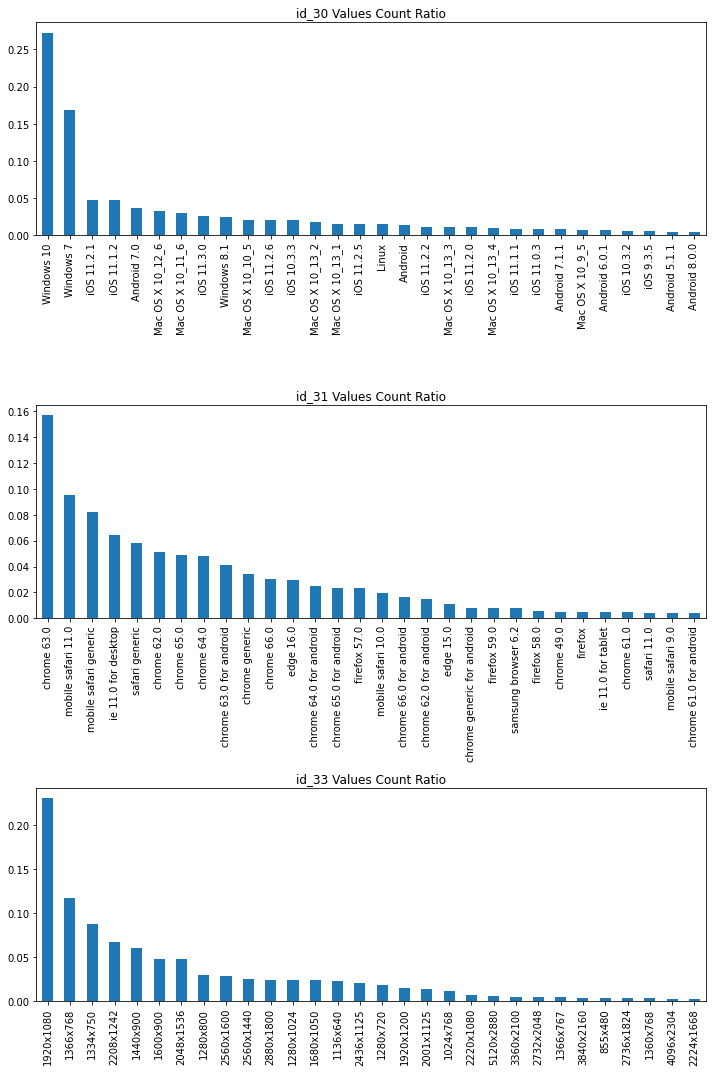

In [19]:
features = ['id_30', 'id_31', 'id_33']

fig, axes = plt.subplots(3,1, figsize=(10,15), tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    df[features[i]].value_counts(dropna=True, normalize=True, ascending=False)[:30]\
      .plot.bar(ax=ax, title=f"{features[i]} Values Count Ratio");

### Device

- `DeviceInfo` are unique for information of device, dominated by broad categories of mobile device.
- `DeviceInfo` have large categories, thousands.

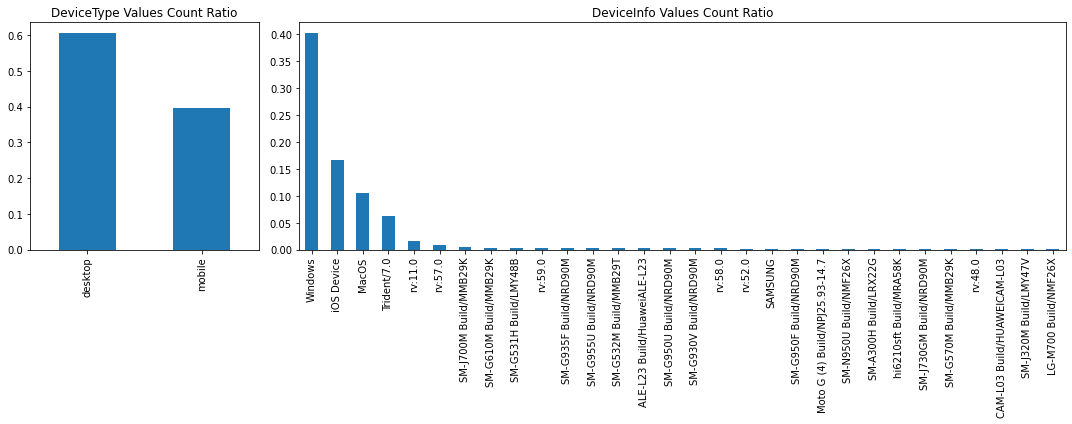

In [20]:
features = ['DeviceType', 'DeviceInfo']

fig = plt.figure(figsize=(15,6), tight_layout=True)
gs = gridspec.GridSpec(1, 4)

fig.add_subplot(gs[0,0])
df['DeviceType'].value_counts(dropna=True, normalize=True, ascending=False)\
  .plot.bar(title='DeviceType Values Count Ratio');

fig.add_subplot(gs[0,1:])
df['DeviceInfo'].value_counts(dropna=True, normalize=True, ascending=False)[:30]\
  .plot.bar(title='DeviceInfo Values Count Ratio');

### ProductCD, Card

- all are categorical feature, but some are already in numeric
- `card4` card type
- `card6` card category
- data contain a little number of missing value about the card

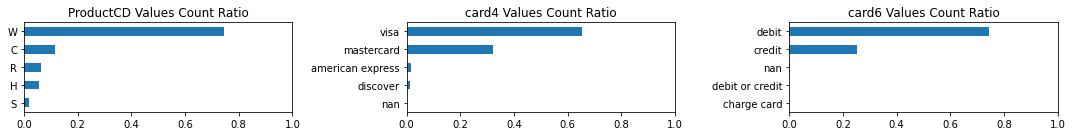

In [21]:
features = ['ProductCD', 'card4', 'card6']

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,2), tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    if i <= len(features)-1:
        df[features[i]].value_counts(dropna=False, normalize=True, ascending=True)\
          .plot.barh(xlim=(0,1), title=f"{features[i]} Values Count Ratio", ax=ax);

In [22]:
features = ['card1', 'card2', 'card3', 'card5']

for feat in features:
  print(f'unique val {feat} :', len(df[feat].unique()) )

unique val card1 : 13553
unique val card2 : 501
unique val card3 : 115
unique val card5 : 120


### Email

- `P_emaildomain`, `R_emaildomain` have large categories.
- `P_emaildomain` have relatively little mising values `R_emaildomain` have significant

In [23]:
features = ['P_emaildomain', 'R_emaildomain']

for feat in features:
  print(f'unique val {feat} :', len(df[feat].unique()) )

unique val P_emaildomain : 60
unique val R_emaildomain : 61


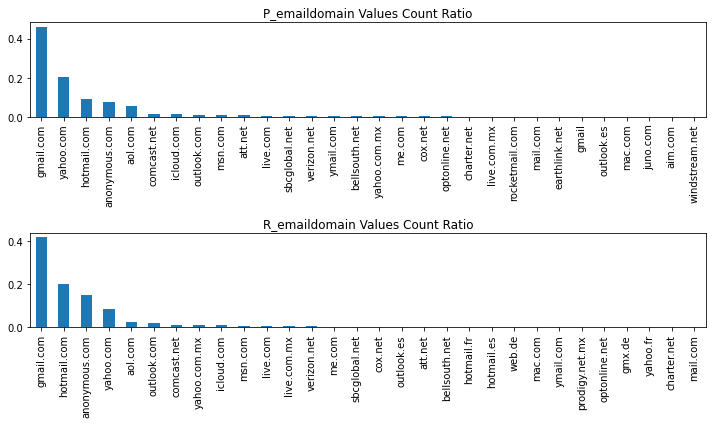

In [24]:
fig, axes = plt.subplots(2,1, figsize=(10,6), tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    df[features[i]].value_counts(dropna=True, normalize=True, ascending=False)[:30]\
      .plot.bar(ax=ax, title=f"{features[i]} Values Count Ratio");

### Addr

- `add1`, `addr2` have large categories.
- `addr2` 88% values are a single specific value, 11% values are missing. seems __not useful__

In [25]:
features = ['addr1', 'addr2']

for feat in features:
  print(f'unique val {feat} :', len(df[feat].unique()) )

unique val addr1 : 333
unique val addr2 : 75


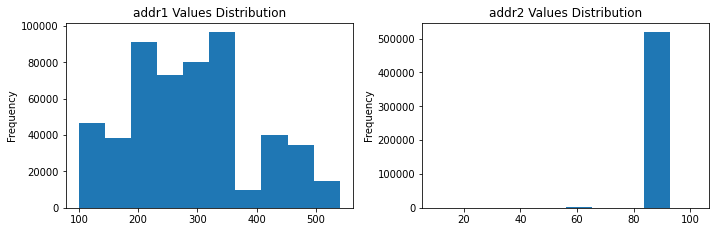

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(15,9), tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    if i <= len(features)-1:
        # display(df[features[i]].value_counts(dropna=False, normalize=True, ascending=False))
        df[features[i]].plot.hist(title=f"{features[i]} Values Distribution", ax=ax);
    else:
        ax.set_visible(False)

### Match

- mostly binary condition

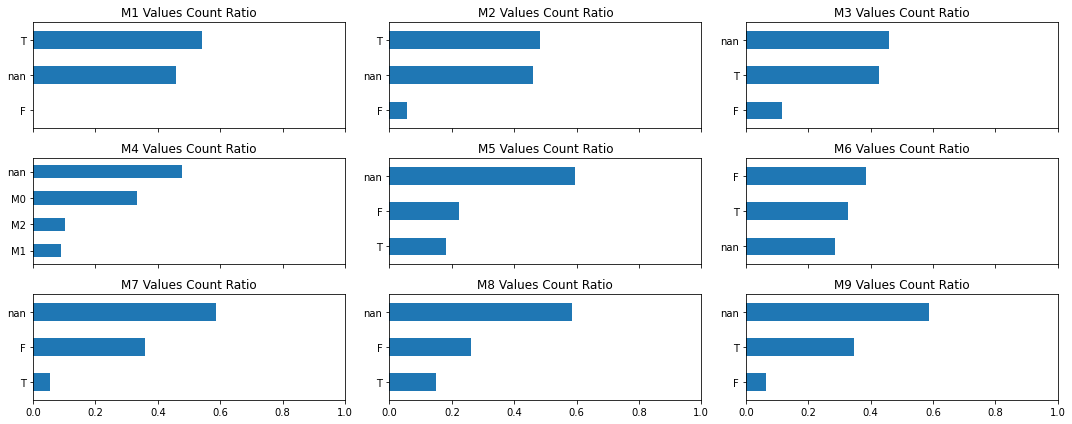

In [27]:
features = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

fig, axes = plt.subplots(3, 3, sharex=True, figsize=(15,6), tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    if i <= len(features)-1:
        df[features[i]].value_counts(dropna=False, normalize=True, ascending=True)\
          .plot.barh(xlim=(0,1), title=f"{features[i]} Values Count Ratio", ax=ax);
    else:
        ax.set_visible(False)

### Counting

- No missing values
- Heavy right skewed

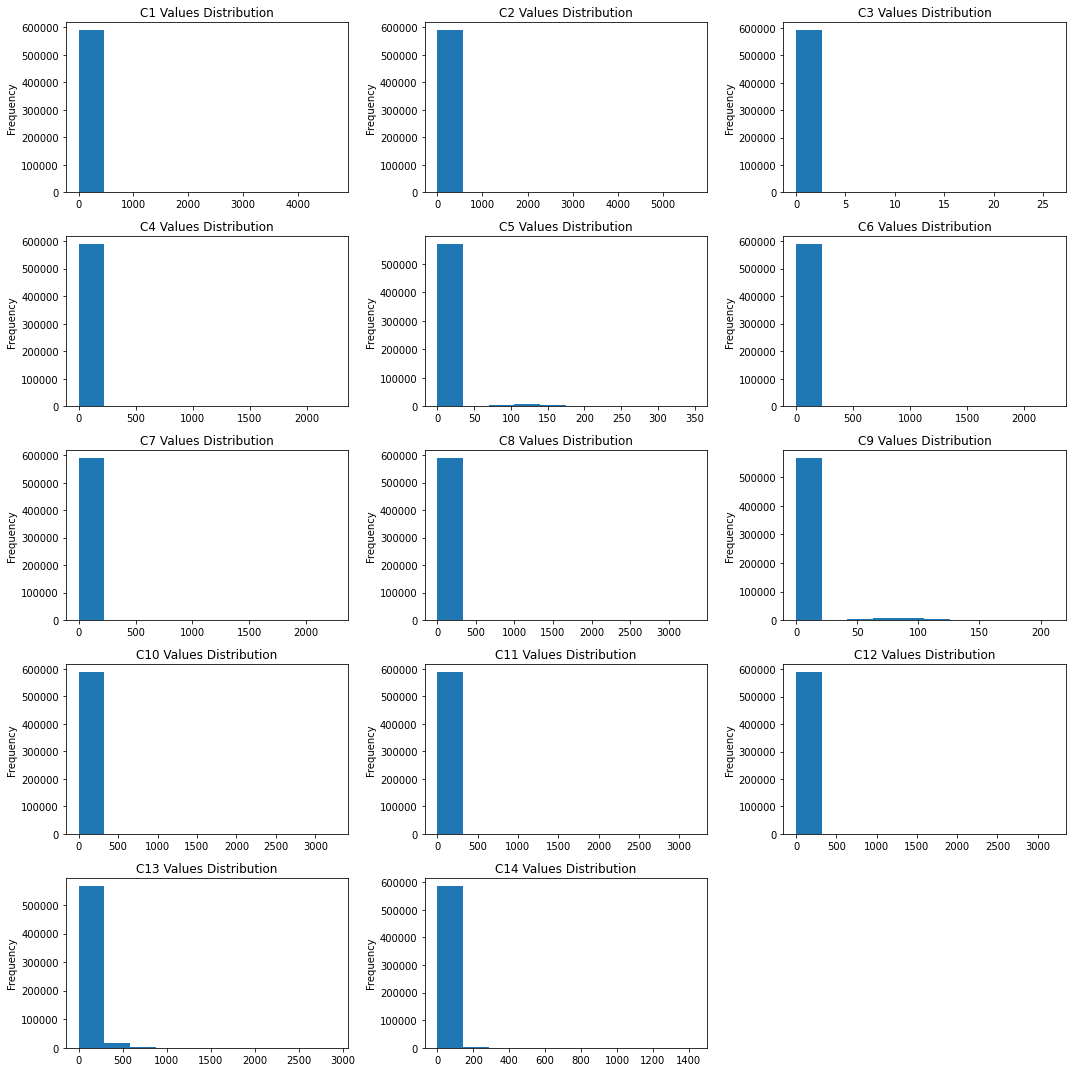

In [28]:
features = [col for col in df.columns if (col[:1] == 'C' and len(col)<=3)]

fig, axes = plt.subplots(5, 3, figsize=(15,15), tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    if i <= len(features)-1:
        df[features[i]].plot.hist(title=f"{features[i]} Values Distribution", ax=ax);
    else:
        ax.set_visible(False)

### Timedelta

- Heavy right skewed

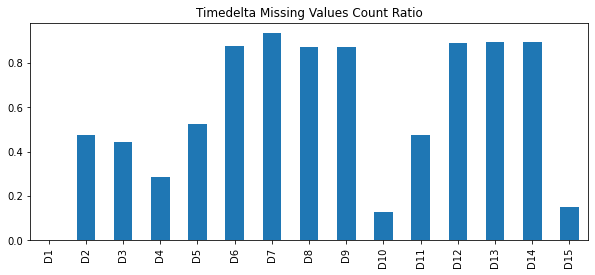

In [29]:
features = [col for col in df.columns if (col[:1] == 'D' and len(col)<=3)]
plt.figure(figsize=(10,4))            
df[features].isna().sum().apply(lambda x: x/len(df)).plot.bar(title="Timedelta Missing Values Count Ratio");

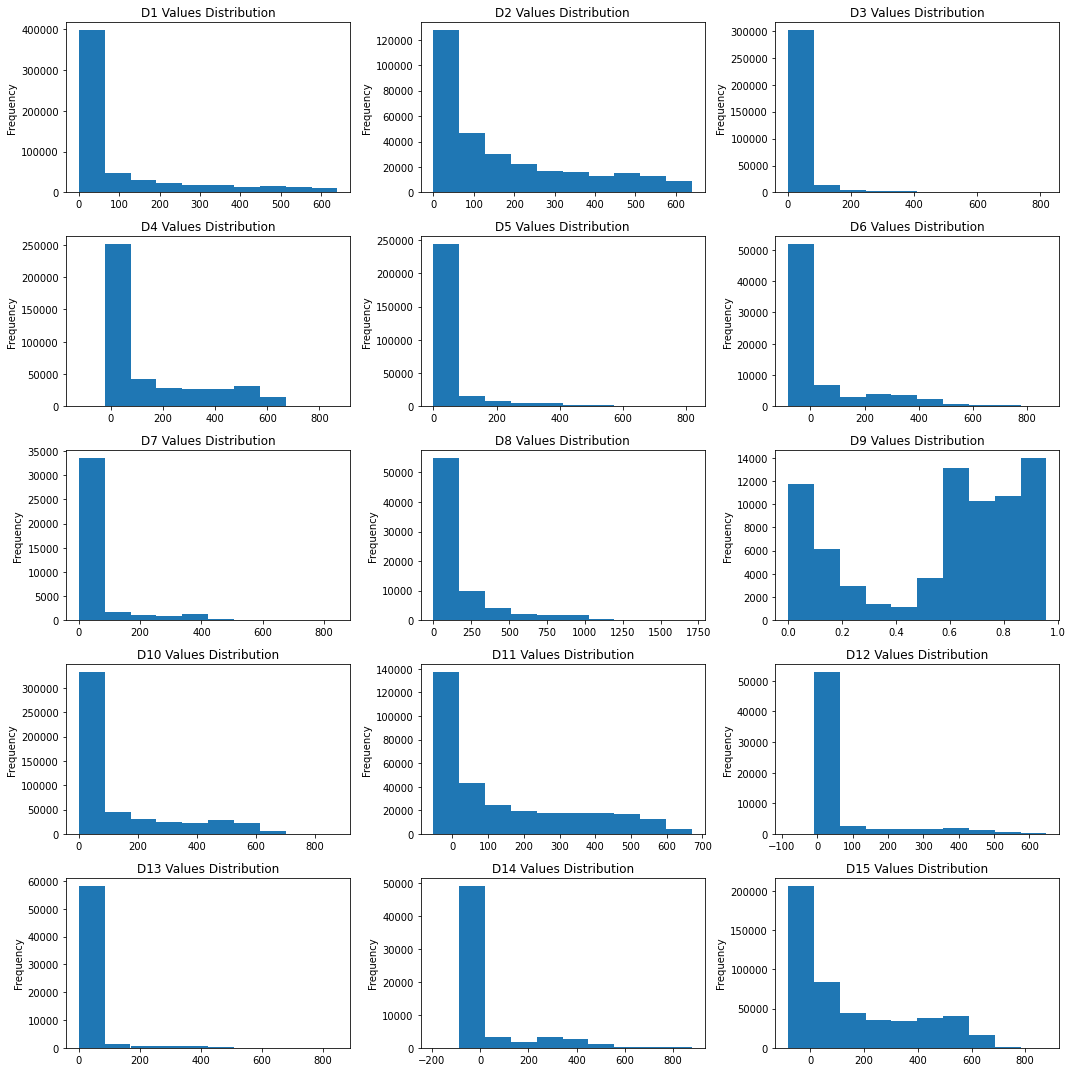

In [30]:
features = [col for col in df.columns if (col[:1] == 'D' and len(col)<=3)]

fig, axes = plt.subplots(5, 3, figsize=(15,15), tight_layout=True)
for i, ax in enumerate(axes.flatten()):
    if i <= len(features)-1:
        df[features[i]].plot.hist(title=f"{features[i]} Values Distribution", ax=ax);
    else:
        ax.set_visible(False)

### TransactionAmt, DT

- `TransactionAmt` heavy right skewed
- `TransactionDT` relatively uniform distributed

### V rich features

- huge number of features
- we dont really know the meaning of the feature
- seems the features in some range were build in same base because of the same number of missing values, correlation, and the illustration in pairplot

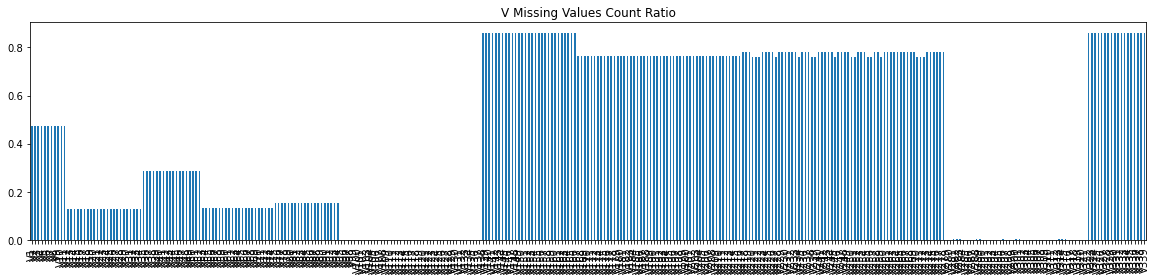

In [31]:
features = [col for col in df.columns if col[:1] == 'V']
plt.figure(figsize=(20,4))            
df[features].isna().sum().apply(lambda x: x/len(df)).plot.bar(title="V Missing Values Count Ratio");

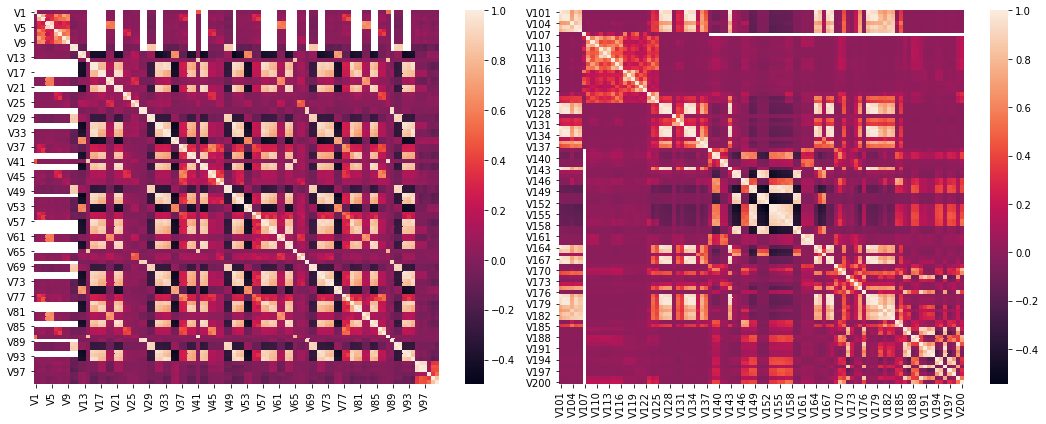

In [32]:
fig, axes = plt.subplots(1,2, figsize=(15,6), tight_layout=True)
sns.heatmap(df[features[:100]].corr(), ax=axes[0]);
sns.heatmap(df[features[100:200]].corr(), ax=axes[1]);

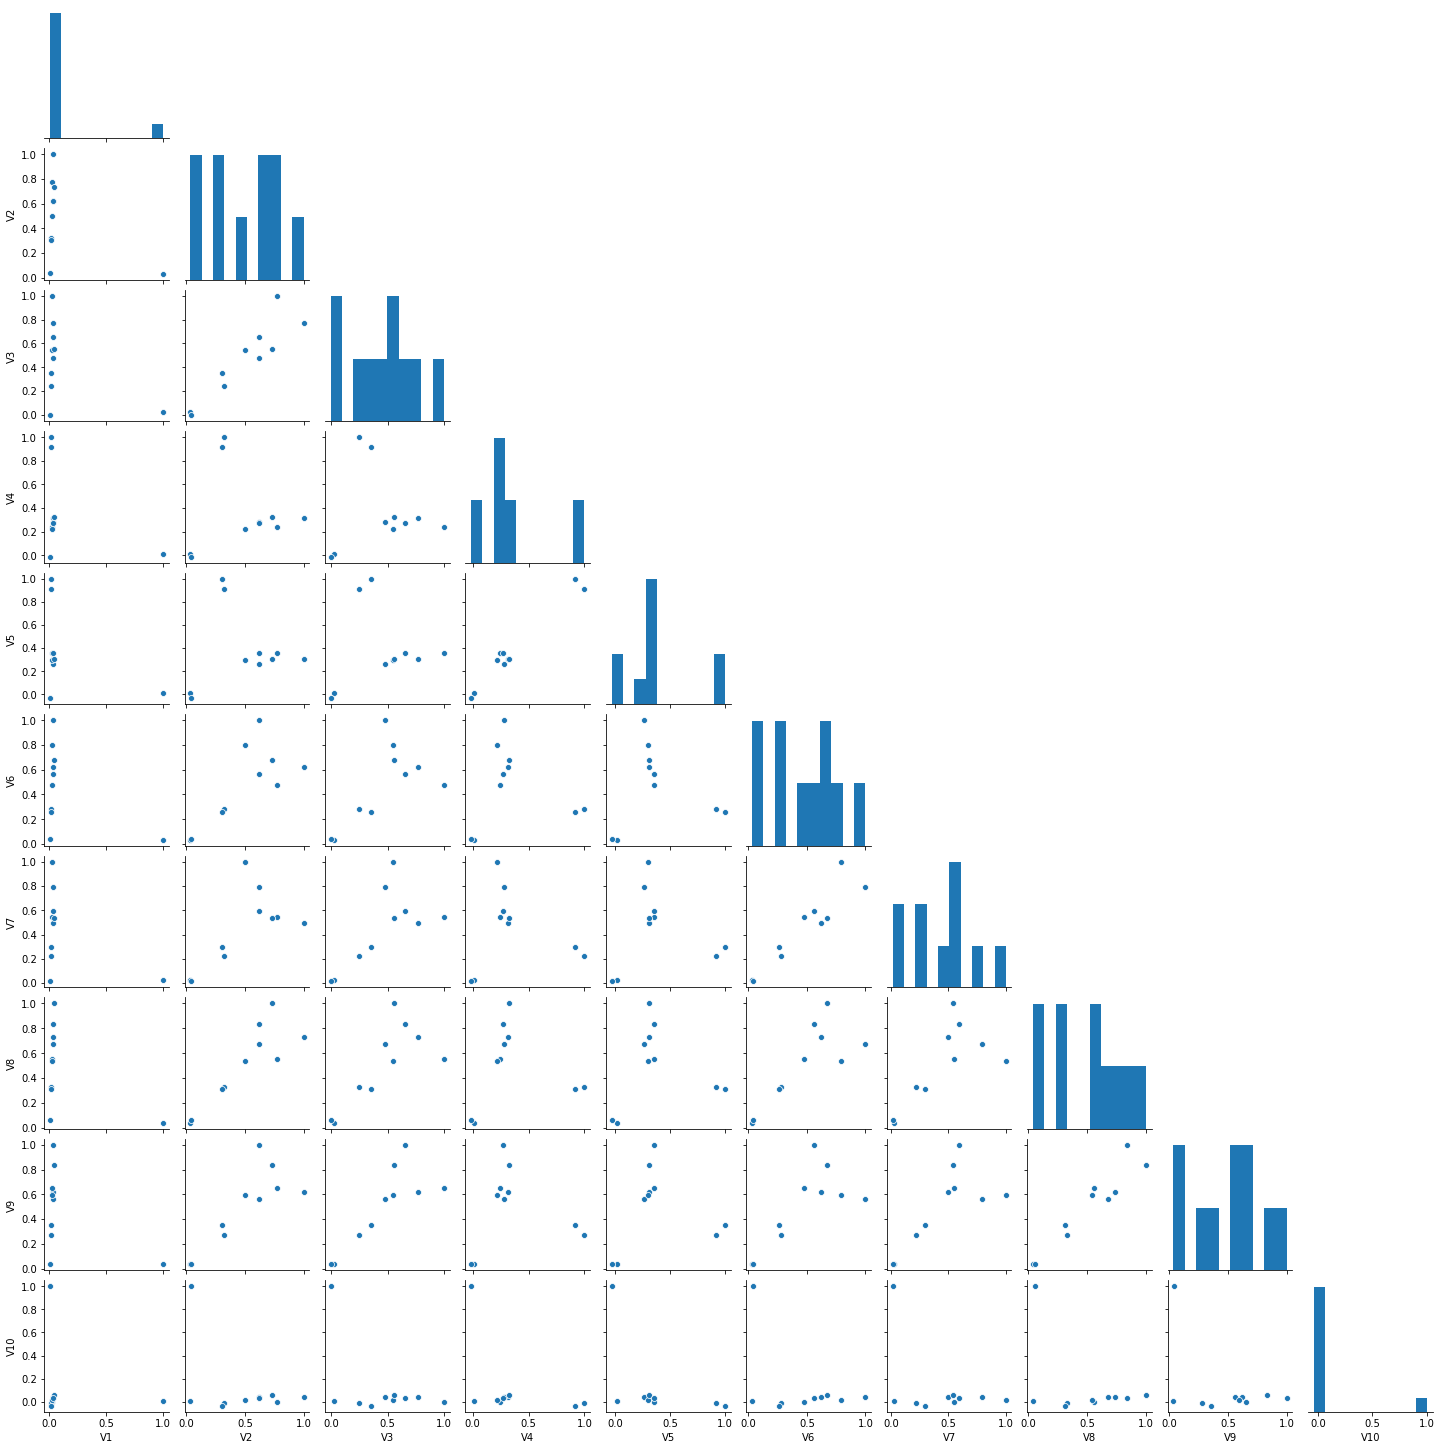

In [33]:
sns.pairplot(df[features[:10]].corr(), height=2, corner=True);

In [34]:
# df_1 = df.copy()
gc.collect()

146526

# 4. Split data

- Before doing feature engineering to avoid leakage
- There are two options: random split and split by timestamp. Use split by timestamp because it makes more sense in the real world. And by looking at the histogram of fraud transaction, it is relatively unrelated to the time.

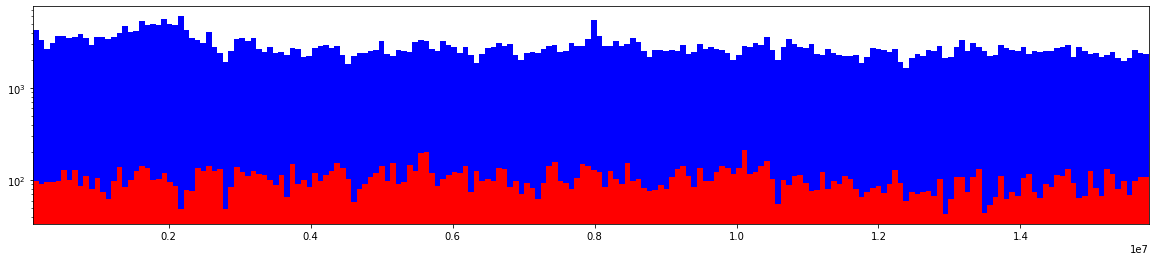

In [35]:
plt.figure(figsize=(20,4))
# plt.hist(df['TransactionDT'], color='blue', bins=200)
plt.hist(df[df['isFraud'] == 0]['TransactionDT'], color='blue', bins=200)
plt.xlim([min(df['TransactionDT']), max(df['TransactionDT'])])
plt.hist(df[df['isFraud'] == 1]['TransactionDT'], color='red', bins=200)
plt.yscale('log')

plt.show()

In [36]:
test_size = .2
test_size = round(len(df)*test_size)
train_df = df.iloc[:-test_size,:]
test_df = df.iloc[-test_size:,:]
del df

label_counts(train_df['isFraud'])
label_counts(test_df['isFraud'])

Not Frauds 96.49 % of the dataset, total of 455833
Frauds 3.51 % of the dataset, total of 16599
Not Frauds 96.56 % of the dataset, total of 114044
Frauds 3.44 % of the dataset, total of 4064


Fraud and not fraud is relatively in similar proportion both in train and test set.

# 5. Feature Engineering

Focus on
1. reducing number of features
2. mapping values to reduce number of categories
3. transformation
4. generate posible good features
5. others

- We know from EDA, mostly categorical columns above are binary condition. I will mainly deal with email, id_30, id_31, id_33, DeviceInfo which have many categories.
- Later will use Label Encoder for the categorical columns, instead of one-hot. Though one-hot is more suitable for the nominal categories, but it will expand the features significantly. So apply Label Encoder to small number of categories is a moderate approach for this case.

In [37]:
display(train_df.shape)
display(test_df.shape)

for col in train_df.select_dtypes(include='object').columns:
  print(col, len(train_df[col].unique()), '-', len(test_df[col].unique()))

(472432, 434)

(118108, 434)

ProductCD 5 - 5
card4 5 - 5
card6 5 - 3
P_emaildomain 60 - 60
R_emaildomain 61 - 59
M1 3 - 3
M2 3 - 3
M3 3 - 3
M4 4 - 4
M5 3 - 3
M6 3 - 3
M7 3 - 3
M8 3 - 3
M9 3 - 3
id_12 3 - 3
id_15 4 - 4
id_16 3 - 3
id_23 4 - 4
id_27 3 - 3
id_28 3 - 3
id_29 3 - 3
id_30 73 - 71
id_31 111 - 105
id_33 213 - 163
id_34 5 - 4
id_35 3 - 3
id_36 3 - 3
id_37 3 - 3
id_38 3 - 3
DeviceType 3 - 3
DeviceInfo 1640 - 849


In [0]:
# set random seed
SEED = 42
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [0]:
# train_df_1 = train_df.copy()
# test_df_1 = test_df.copy()

### Reducing number of features by common problems

- drop columns which have many null values
- drop columns which only dominated by one value
- drop useless features
  - `TransactionID` must not affected the model since it is generic
  - `TransactionDT` cant be interpreted. unless some reasonable feature engineering applied like aggregating or else.



In [40]:
# train_df = train_df_1.copy()
# test_df = test_df_1.copy()

many_null_cols = [col for col in train_df.columns if train_df[col].isnull().sum()/train_df.shape[0] > 0.9]
big_top_value_cols = [col for col in train_df.columns if train_df[col].value_counts(dropna=True, normalize=True).values[0] > 0.9]
useless_cols = ['TransactionID', 'TransactionDT']

cols_to_drop = list(set(many_null_cols + big_top_value_cols + useless_cols))
cols_to_drop.remove('isFraud')

display(len(cols_to_drop))
# display(cols_to_drop)

train_df.drop(cols_to_drop, axis=1, inplace=True)
test_df.drop(cols_to_drop, axis=1, inplace=True)

177

In [41]:
display(train_df.shape)
display(test_df.shape)

(472432, 257)

(118108, 257)

### PCA for V rich features

- There is no specific informations tell what the value actually means
- The number of these features is huge so the conventional approach for feature engineering is somehow difficult
- The values are numeric and many high correlation detected
- PCA will reduce to designated number of principal components. But to be noted, the initial features have many missing values that actually cant be handled by PCA.
- In this case, I state 95% of variances should be explained
- 198 features reduced to 27 features

In [43]:
features = [col for col in train_df.columns if col[:1] == 'V']
display(train_df[features].shape)
display(test_df[features].shape)

n_components = 0.95
prefix = 'V_pc_'

pca_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=n_components, random_state=SEED)),
    ]) 
pca_pipeline.fit(train_df[features])
# PCA.explained_variance_ratio_

temp = pca_pipeline.transform(train_df[features])
V_pc_train_df = pd.DataFrame(temp, index=train_df.index)
V_pc_train_df.rename(columns=lambda x: str(prefix)+str(x), inplace=True)
train_df = pd.concat([train_df.drop(features, axis=1), V_pc_train_df], axis=1)
display(V_pc_train_df.shape, train_df.shape)

temp = pca_pipeline.transform(test_df[features])
V_pc_test_df = pd.DataFrame(temp, index=test_df.index)
V_pc_test_df.rename(columns=lambda x: str(prefix)+str(x), inplace=True)
test_df = pd.concat([test_df.drop(features, axis=1), V_pc_test_df], axis=1)
display(V_pc_test_df.shape, test_df.shape)

(472432, 185)

(118108, 185)

(472432, 28)

(472432, 100)

(118108, 28)

(118108, 100)

### Reducing number of categories

- `P_emaildomain`,`R_emaildomain` mapping emails, reduce from ~60 classes to 10
- `DeviceInfo` mapping device, reduce from thousands to 16
- `id_30` mapping device, reduce from 80s to 8
- `id_31` mapping device, reduce from hundreds to 8
- `id_33` mapping device, reduce from thousands to 8, already convert to numeric

In [44]:
# insights from
# kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
# kaggle.com/ysjf13/cis-fraud-detection-visualize-feature-engineering

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}


for col in ['P_emaildomain', 'R_emaildomain']:
    train_df[col] = train_df[col].map(emails)
    test_df[col] = train_df[col].map(emails)
    # df[col + '_bin'] = df[col].map(emails)
    # df[col + '_suffix'] = df[col].map(lambda x: str(x).split('.')[-1])

display(len(train_df['P_emaildomain'].unique()), len(test_df['P_emaildomain'].unique()))
display(len(train_df['R_emaildomain'].unique()), len(test_df['R_emaildomain'].unique()))

10

1

10

1

In [45]:
def map_DeviceInfo(df, train=True, col='DeviceInfo'):
    
    df['have_DeviceInfo'] = df[col].isna().astype(int)
    
    df[col] = df[col].fillna('unknown').str.lower()
    df[col] = df[col].str.split('/', expand=True)[0]
    df[col] = df[col].apply(lambda x: x.lower())

    df.loc[df[col].str.contains('windows', na=False), col] = 'Windows'
    df.loc[df[col].str.contains('sm-', na=False), col] = 'Samsung'
    df.loc[df[col].str.contains('samsung', na=False), col] = 'Samsung'
    df.loc[df[col].str.contains('gt-', na=False), col] = 'Samsung'
    df.loc[df[col].str.contains('moto', na=False), col] = 'Motorola'
    df.loc[df[col].str.contains('lg-', na=False), col] = 'LG'
    df.loc[df[col].str.contains('rv:', na=False), col] = 'RV'
    df.loc[df[col].str.contains('huawei', na=False), col] = 'Huawei'
    df.loc[df[col].str.contains('ale-', na=False), col] = 'Huawei'
    df.loc[df[col].str.contains('-l', na=False), col] = 'Huawei'
    df.loc[df[col].str.contains('hi6', na=False), col] = 'Huawei'
    df.loc[df[col].str.contains('blade', na=False), col] = 'ZTE'
    df.loc[df[col].str.contains('trident', na=False), col] = 'Trident'
    df.loc[df[col].str.contains('lenovo', na=False), col] = 'Lenovo'
    df.loc[df[col].str.contains('xt', na=False), col] = 'Sony'
    df.loc[df[col].str.contains('f3', na=False), col] = 'Sony'
    df.loc[df[col].str.contains('f5', na=False), col] = 'Sony'
    df.loc[df[col].str.contains('lt', na=False), col] = 'Sony'
    df.loc[df[col].str.contains('htc', na=False), col] = 'HTC'
    df.loc[df[col].str.contains('mi', na=False), col] = 'Xiaomi'

    if train:
      df.loc[df[col].isin(df[col].value_counts()[df[col].value_counts() < 100].index), col] = "other"
      pass
    else:
      cat_so_far = ['unknown', 'windows', 'ios device', 'macos', 'Samsung', 'Trident', 'RV',
                    'Motorola', 'Huawei', 'LG', 'Sony', 'ZTE', 'HTC', 'Lenovo', 'Xiaomi']
      df[col] = df[col].apply(lambda x: x if x in cat_so_far else 'other')
    
    gc.collect()
    return df

train_df = map_DeviceInfo(train_df)
test_df = map_DeviceInfo(test_df, train=False)
display(len(train_df['DeviceInfo'].unique()),
        len(test_df['DeviceInfo'].unique())
        )

16

15

In [46]:
def map_id30(df, col='id_30'):
    
    df['have_id30'] = df[col].isna().astype(int)
    
    df[col] = df[col].fillna('unknown')
    df[col] = df[col].str.split(' ', expand=True)[0]
    
    gc.collect()
    return df

train_df = map_id30(train_df)
test_df = map_id30(test_df)
display(len(train_df['id_30'].unique()),
        len(test_df['id_30'].unique())
        )

8

7

In [47]:
def map_id31(df, col='id_31'):
    
    df['have_id31'] = df[col].isna().astype(int)
    
    df[col] = df[col].fillna('unknown')

    df.loc[df[col].str.contains('chrome', na=False), col] = 'chrome'
    df.loc[df[col].str.contains('safari', na=False), col] = 'safari'
    df.loc[df[col].str.contains('firefox', na=False), col] = 'firefox'
    df.loc[df[col].str.contains('edge', na=False), col] = 'edge'
    df.loc[df[col].str.contains('ie', na=False), col] = 'ie'
    df.loc[df[col].str.contains('android', na=False), col] = 'default'
    df.loc[df[col].str.contains('samsung', na=False), col] = 'default'
    df.loc[df[col].str.contains('browser', na=False), col] = 'default'

    df.loc[df[col].isin(df[col].value_counts()[df[col].value_counts() < 200].index), col] = "other"

    gc.collect()
    return df

train_df = map_id31(train_df)
test_df = map_id31(test_df)
display(len(train_df['id_31'].unique()),
        len(test_df['id_31'].unique()),
        )

8

8

In [48]:
def map_id33(df, col='id_33'):
    
    df['have_id33'] = df[col].isna().astype(int)
    
    df[col] = df[col].fillna('0')
    df[col] = df[col].str.split('x', expand=True)[0].astype(int)
    df[col] = df[col].map(lambda x: int(x/1000))

    gc.collect()
    return df

train_df = map_id33(train_df)
test_df = map_id33(test_df)
display(len(train_df['id_33'].unique()),
        len(test_df['id_33'].unique()),
        )

8

6

In [49]:
display(train_df.shape)
display(test_df.shape)

for col in train_df.select_dtypes(include='object').columns:
    print(col, len(train_df[col].unique()), '-', len(test_df[col].unique()))

(472432, 104)

(118108, 104)

ProductCD 5 - 5
card4 5 - 5
card6 5 - 3
P_emaildomain 10 - 1
R_emaildomain 10 - 1
M2 3 - 3
M3 3 - 3
M4 4 - 4
M5 3 - 3
M6 3 - 3
M7 3 - 3
M8 3 - 3
M9 3 - 3
id_12 3 - 3
id_15 4 - 4
id_16 3 - 3
id_28 3 - 3
id_29 3 - 3
id_30 8 - 7
id_31 8 - 8
id_34 5 - 4
id_35 3 - 3
id_37 3 - 3
id_38 3 - 3
DeviceType 3 - 3
DeviceInfo 16 - 15


In [0]:
# train_df_2 = train_df.copy()
# test_df_2 = test_df.copy()

### Generate posible good features

### Impute remaining null values

Decide to use median for numeric features and most_frequent for categorical features since both most robust to outliers.

In [0]:
# train_df = train_df_2.copy()
# test_df = test_df_2.copy()

y_train = train_df['isFraud'].values
y_test = test_df['isFraud'].values

In [0]:
cat_features = list(train_df.select_dtypes(include=['object']).columns)
num_features = list(train_df.select_dtypes(exclude=['object']).columns)
num_features.remove('isFraud')

In [0]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attr):
        self.attributes = attr
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes].values

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_features)),
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
    ]) 

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_features)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
    ])

imputer_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [0]:
imputer_pipeline.fit(train_df)
train_df = pd.DataFrame(imputer_pipeline.transform(train_df), columns=num_features+cat_features)
test_df = pd.DataFrame(imputer_pipeline.transform(test_df), columns=num_features+cat_features)

### Encode categorical

Since through reducing number of categories process, I always monitor that train set cover all categories that test set have. The encoding process will not suffer much.

In [0]:
def encodeCategorical(train, test):
    for feat in cat_features:
        le = LabelEncoder()
        le.fit(train[feat])
        train[feat] = le.transform(train[feat])
        test[feat] = le.transform(test[feat])
    return train, test

In [57]:
X_train, X_test = encodeCategorical(train_df, test_df)

del train_df
del test_df
gc.collect()

277

### Transformation

In [0]:
# later use
# train['TransactionAmt'] = np.log1p(train['TransactionAmt'])

# 6. Save Final DataFrame

In [70]:
folder_path = './drive/My Drive/Colab Notebooks/purwadhika/'

pd.concat([X_train, pd.Series(y_train, name='isFraud')], axis=1).to_csv(folder_path+'train.csv',index=False)
pd.concat([X_test, pd.Series(y_test, name='isFraud')], axis=1).to_csv(folder_path+'test.csv',index=False)

display(X_train.shape, y_train.shape)
display(X_test.shape, y_test.shape)

(472432, 103)

(472432,)

(118108, 103)

(118108,)